# Investigating Machine Learning Models Performance for Interpolation of Meterological Data
### Eli Simic Robertson
### Sentient Hubs Internship Short Project

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
# add tftimeseries.py file path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'MastersDissertation', 'nbs', 'glassnode')))
from tftimeseries import *

%matplotlib inline

RESPONSE_VAR = 'temperature'
WINDOW_SIZE = 7
CONV_WIDTH = 3

In [100]:
df_temp = pd.read_csv('./hourly_weather_kaggle/temperature.csv')
df_humid = pd.read_csv('./hourly_weather_kaggle/humidity.csv')
df_press = pd.read_csv('./hourly_weather_kaggle/pressure.csv')
df_wind_d = pd.read_csv('./hourly_weather_kaggle/wind_direction.csv')
df_wind_s = pd.read_csv('./hourly_weather_kaggle/wind_speed.csv')

# Make dataframe for all Los Angeles weather continuous data features
df = df_temp[['datetime', 'Los Angeles']].rename(columns={'Los Angeles': 'temperature'})

df = df.merge(df_humid[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'humidity'}))
df = df.merge(df_press[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'pressure'}))
df = df.merge(df_wind_d[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_d'}))
df = df.merge(df_wind_s[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_s'}))


df['datetime'] = pd.to_datetime(df['datetime'])

df.head(5)

,datetime,temperature,humidity,pressure,wind_d,wind_s
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,291.870000,88.0,1013.0,0.0,0.0
2,2012-10-01 14:00:00,291.868186,88.0,1013.0,0.0,0.0
3,2012-10-01 15:00:00,291.862844,88.0,1013.0,0.0,0.0
4,2012-10-01 16:00:00,291.857503,88.0,1013.0,0.0,0.0


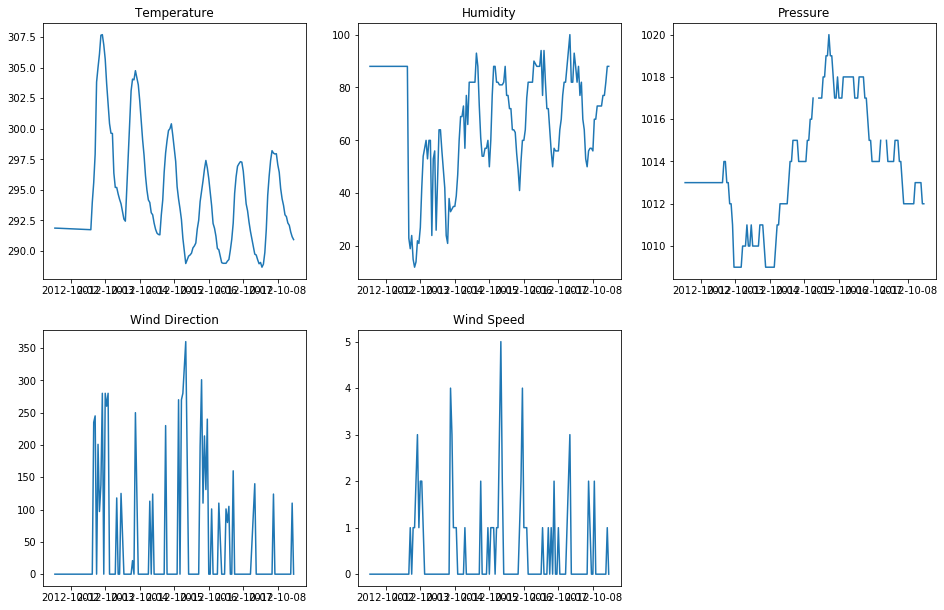

In [101]:
week = 24 * 7
df_1w = df.iloc[:week, :]

plt.figure(figsize=(16, 16))
plt.subplot(331)
plt.plot(df_1w['datetime'], df_1w['temperature'])
plt.title('Temperature')
plt.subplot(332)
plt.plot(df_1w['datetime'], df_1w['humidity'])
plt.title('Humidity')
plt.subplot(333)
plt.plot(df_1w['datetime'], df_1w['pressure'])
plt.title('Pressure')
plt.subplot(334)
plt.plot(df_1w['datetime'], df_1w['wind_d'])
plt.title('Wind Direction')
plt.subplot(335)
plt.plot(df_1w['datetime'], df_1w['wind_s'])
plt.title('Wind Speed');

In [102]:
df.isna().sum()

datetime         0
temperature      3
humidity       152
pressure       252
wind_d           1
wind_s           1
dtype: int64

In [103]:
252 / df.shape[0]

0.0055686915784588864

In [104]:
df = df.interpolate(method='linear').dropna()
df.isna().sum().sum()

0

#### Methodology 
- Create artificially noisy dataset
- Benchmark conventional interpolation techniques
- Train various Machine Learning models on Weather data to predict **Temperature**.
- Compare Model Predictions with Test dataset.
- Benchmark ML models performances against conventional interpolation techniques.

## Create Artificially Noisy Dataset
- Create 10% missing temperature data.

In [105]:
# Convert date col to numeric representation.

datetime = df['datetime']

df = date_periodicity(df, date_col='datetime')

train_df, val_df, test_df = split_df(df)


noisy_test_df = test_df.copy()

In [64]:
noisy_test_df['temperature'].isna().sum()

0

In [222]:
noise_level = 0.2
n_gaps = int(noisy_test_df.shape[0] * noise_level)
# randomly choose gap indexes
gap_indxs = np.random.choice(a=noisy_test_df.shape[0], size=n_gaps, replace=False)

noisy_test_df['temperature'].iloc[gap_indxs] = np.nan

In [223]:
noisy_test_df['temperature'].isna().sum()

905

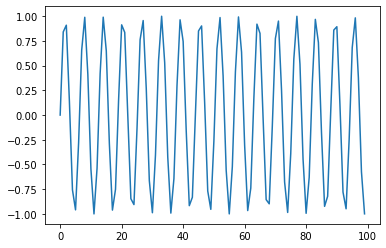

In [68]:
plt.plot(np.arange(noisy_test_df[:100].shape[0]), np.sin(np.arange(noisy_test_df[:100].shape[0])))

In [69]:
# generate a range of vals (0 ... n_rows)
idxs = np.arange(noisy_test_df.shape[0])
# generate a sin wave onto range
noisy_test_df_sin = np.sin(idxs) ** 2
# use sum as denominator to make the sin vals total to 1.
sum_idxs = np.sum(noisy_test_df_sin)

prob = noisy_test_df_sin / sum_idxs
# check the sum of sin's totals to 1.
assert int(np.sum(prob)) == 1

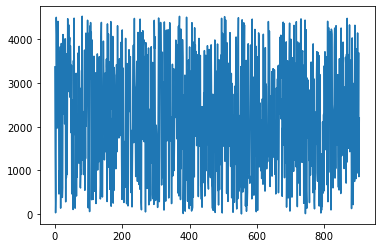

In [70]:
noise_level = 0.2
n_gaps = int(noisy_test_df.shape[0] * noise_level)
# randomly choose gap indexes
gap_indxs = np.random.choice(a=noisy_test_df.shape[0], size=n_gaps, replace=False, p=prob)

In [203]:
noisy_test_df = test_df.copy()

noisy_test_df['temperature'].iloc[gap_indxs] = np.nan

In [158]:
def plot_noisy_series(complete_series, noisy_series, noise_level=noise_level):
    '''
        Inputs:
            complete_series: Series containing all values.
            noisy_series: Series containing missing values due to artifical noise.
            noise_level: Amount of noise imposed on Series(for plotting).
    '''
    
    
    # extract datetimes for df indexing
    test_datetimes =  datetime[-test_df.shape[0]:]
    # Create df for easy plotting
    df_temp_all = pd.DataFrame({'Complete': complete_series,
                                'Noisy': noisy_series}).set_index(test_datetimes)

    # Create a indicator column for missing temperature value.
    df_temp_all = df_temp_all.assign(missing=np.nan)
    df_temp_all['Missing'] = df_temp_all[df_temp_all['Noisy'].isna()]['Complete']
    
    styles=['k--', 'bo-', 'r*']
    df_temp_all[:100].plot(style=styles, figsize=(20,10));
    plt.title(f'Missing Temperature Values at Noise Level: {noise_level}')
    plt.ylabel('Temperature');

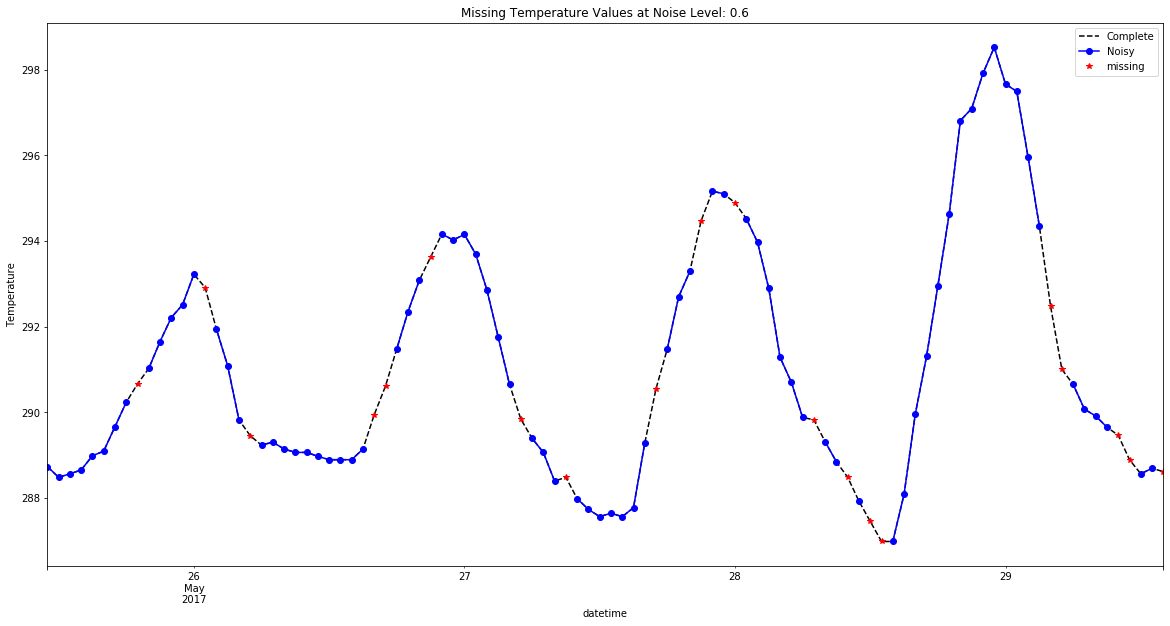

In [159]:
plot_noisy_series(test_df['temperature'], noisy_test_df[RESPONSE_VAR])

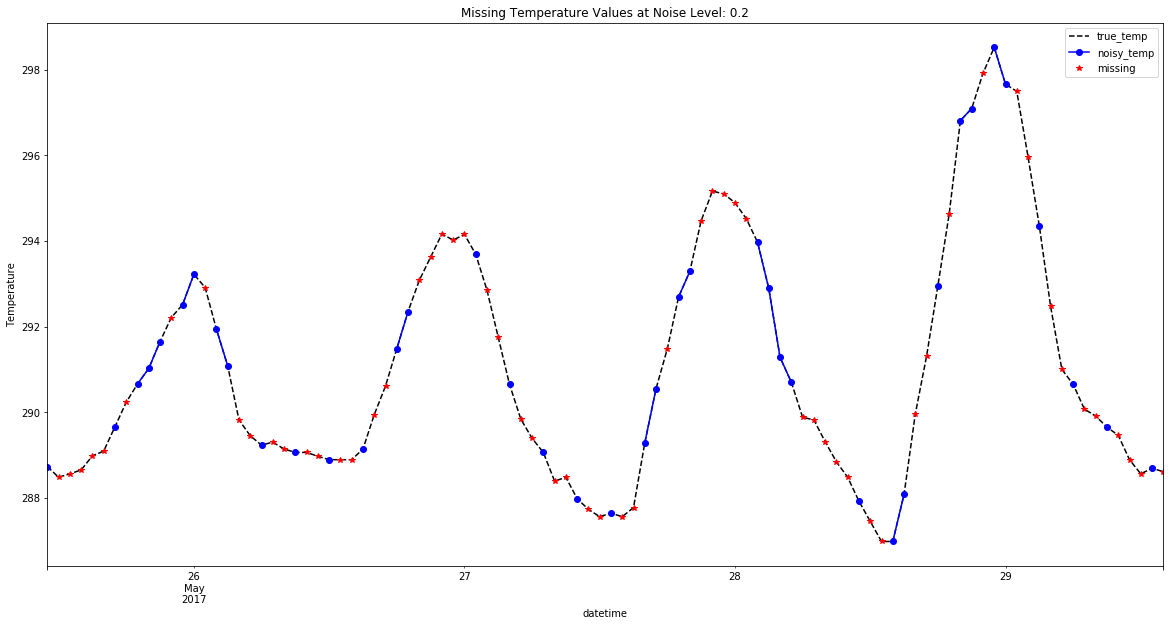

In [152]:
noise_level = 0.6
n_gaps = int(noisy_test_df.shape[0] * noise_level)
# randomly choose gap indexes
gap_indxs = np.random.choice(a=noisy_test_df.shape[0], size=n_gaps, replace=False, p=prob)

noisy_test_df_40 = test_df.copy()

noisy_test_df_40['temperature'].iloc[gap_indxs] = np.nan

plot_noisy_series(test_df, noisy_test_df_40)

#### Plotting Noisy Data

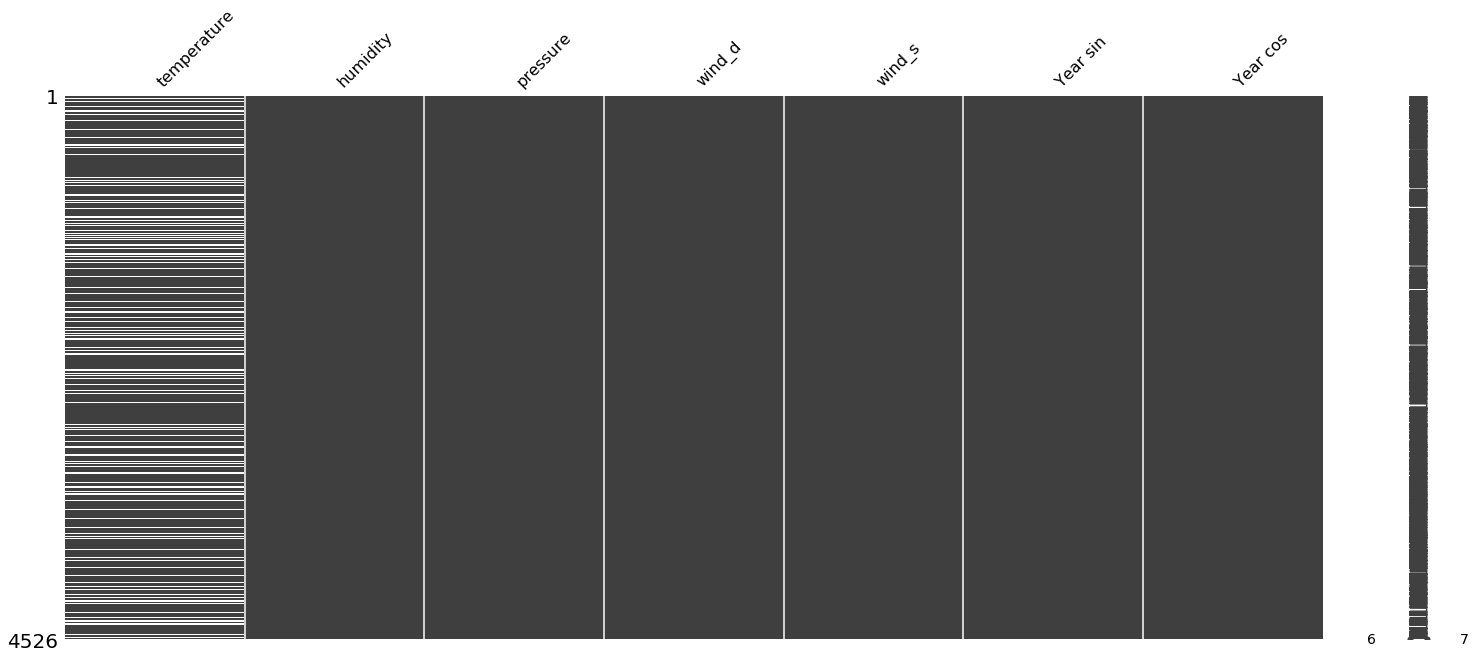

In [72]:
import missingno as msno

msno.matrix(noisy_test_df);

In [73]:
methods = ['linear', 'index', 'pad', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline',
           'polynomial', 'piecewise_polynomial', 'spline', 'pchip', 'akima',
      'cubicspline', 'from_derivatives']

mses = []

for method in methods:
    order = 2
    temp_int = noisy_test_df['temperature'].interpolate(method=method, order=order)
    # fill if method creates NA val
    temp_int = temp_int.fillna(method='bfill').fillna(method='ffill')
    mse = mean_squared_error(test_df['temperature'], temp_int)

    mses.append(mse)

In [74]:
pd.DataFrame({"method": methods, "MSE": mses}).sort_values(by='MSE', ascending=True)

,method,MSE
13,akima,0.037764
6,quadratic,0.038926
9,polynomial,0.038926
12,pchip,0.039277
7,cubic,0.039578
14,cubicspline,0.039578
5,slinear,0.051099
0,linear,0.051099
1,index,0.051099
10,piecewise_polynomial,0.051099


## Linear Model

In [75]:
train_df, val_df, test_df = split_df(df)

# num_features = df.shape[1]

train_df, val_df, test_df, scaler = scale_datasets(train_df, val_df,
                                                   test_df, dependent=RESPONSE_VAR)

#### Windowing data

In [169]:
window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=[RESPONSE_VAR],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['temperature']

In [171]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

compile_and_fit(linear, window)

Epoch 1/20
990/990 [==============================] - 2s 2ms/step - loss: 85549.7031 - mean_absolute_error: 217.7253 - mean_absolute_percentage_error: 75.1154 - val_loss: 190.8744 - val_mean_absolute_error: 11.3870 - val_mean_absolute_percentage_error: 3.9258
Epoch 2/20
990/990 [==============================] - 1s 1ms/step - loss: 144.1546 - mean_absolute_error: 10.0129 - mean_absolute_percentage_error: 3.4614 - val_loss: 115.1962 - val_mean_absolute_error: 8.9311 - val_mean_absolute_percentage_error: 3.0502
Epoch 3/20
990/990 [==============================] - 1s 1ms/step - loss: 64.1996 - mean_absolute_error: 6.4143 - mean_absolute_percentage_error: 2.2149 - val_loss: 59.9719 - val_mean_absolute_error: 6.0802 - val_mean_absolute_percentage_error: 2.0719
Epoch 4/20
990/990 [==============================] - 1s 1ms/step - loss: 34.4950 - mean_absolute_error: 4.5338 - mean_absolute_percentage_error: 1.5657 - val_loss: 43.8556 - val_mean_absolute_error: 5.0572 - val_mean_absolute_percen

### Convert Predictions into Interpolation Function
- find nans indexes 
- get preceeding 7 indexes for nan indexes, if index < 7 => interpolate with conventional method
- feed 7 size window to model
- merge prediction into noisy dataframe

In [230]:
def model_interpolate(model, window, noisy_test_df, window_size=WINDOW_SIZE):
    # Interpolate the first n-window-size to enable further interpolation.
    noisy_test_df.iloc[:window_size] = noisy_test_df.iloc[:window_size].interpolate(method='akima')
    noisy_test_array = noisy_test_df[RESPONSE_VAR].to_numpy()
    
    print(np.isnan(noisy_test_array).sum())
    
    # Get indexes of nan values, index to 0th dimension (ugly)
    nan_indxs = np.where(np.isnan(noisy_test_array))[0]
    
    print(nan_indxs)

    for nan_indx in nan_indxs:
#         break
        # Make a prediction for the NaN
        preds = model.predict(window.test_df[nan_indx - window_size: nan_indx])
        # Insert the pred inplace of the NaN
        np.put(noisy_test_array, nan_indx, preds[-1])
        
    return noisy_test_array

In [231]:
interp_linear = model_interpolate(linear, window, noisy_test_df)

0
[]


In [229]:
np.isnan(noisy_test_df[RESPONSE_VAR].to_numpy()).sum()

0

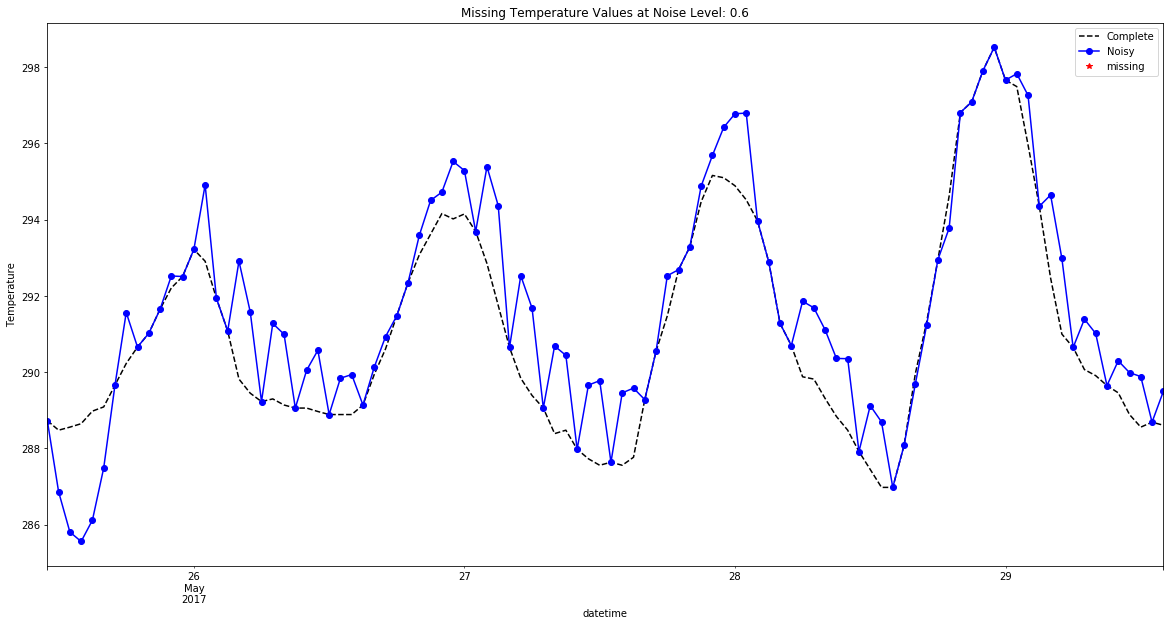

In [209]:
plot_noisy_series(test_df[RESPONSE_VAR], interp_linear)

In [210]:
def score_interpolation(interpolated_array, test_array, metric=mean_squared_error):
    return metric(test_array, interpolated_array) 

In [211]:
score_interpolation(interp_linear, test_df[RESPONSE_VAR])

1.4239451943283568

In [179]:
CONV_WINDOW_SIZE = WINDOW_SIZE - 2

textbook_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))

])

conv_window = WindowGenerator(
    input_width=CONV_WINDOW_SIZE + (CONV_WIDTH - 1), label_width=CONV_WINDOW_SIZE, shift=1,
    label_columns=[RESPONSE_VAR],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

# window
compile_and_fit(textbook_model, conv_window)

Epoch 1/20
990/990 [==============================] - 9s 6ms/step - loss: 70768.7109 - mean_absolute_error: 265.7425 - mean_absolute_percentage_error: 91.5847 - val_loss: 62532.0039 - val_mean_absolute_error: 249.9820 - val_mean_absolute_percentage_error: 85.8139
Epoch 2/20
990/990 [==============================] - 6s 6ms/step - loss: 54572.2852 - mean_absolute_error: 233.3501 - mean_absolute_percentage_error: 80.4150 - val_loss: 48105.9102 - val_mean_absolute_error: 219.2371 - val_mean_absolute_percentage_error: 75.2540
Epoch 3/20
990/990 [==============================] - 6s 6ms/step - loss: 41463.0430 - mean_absolute_error: 203.3465 - mean_absolute_percentage_error: 70.0692 - val_loss: 36094.7852 - val_mean_absolute_error: 189.8783 - val_mean_absolute_percentage_error: 65.1700
Epoch 4/20
990/990 [==============================] - 6s 6ms/step - loss: 30565.3066 - mean_absolute_error: 174.5193 - mean_absolute_percentage_error: 60.1289 - val_loss: 26141.0566 - val_mean_absolute_error:

In [186]:
textbook_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 5, 64)             1408      
_________________________________________________________________
gru_14 (GRU)                 (None, 5, 32)             9408      
_________________________________________________________________
gru_15 (GRU)                 (None, 5, 32)             6336      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 5, 1)              33        
Total params: 17,185
Trainable params: 17,185
Non-trainable params: 0
_________________________________________________________________


In [212]:
interp_textbook = model_interpolate(model=textbook_model, window=conv_window, noisy_test_df=noisy_test_df)

[]


In [182]:
interp_textbook == interp_linear

array([ True,  True,  True, ...,  True,  True,  True])

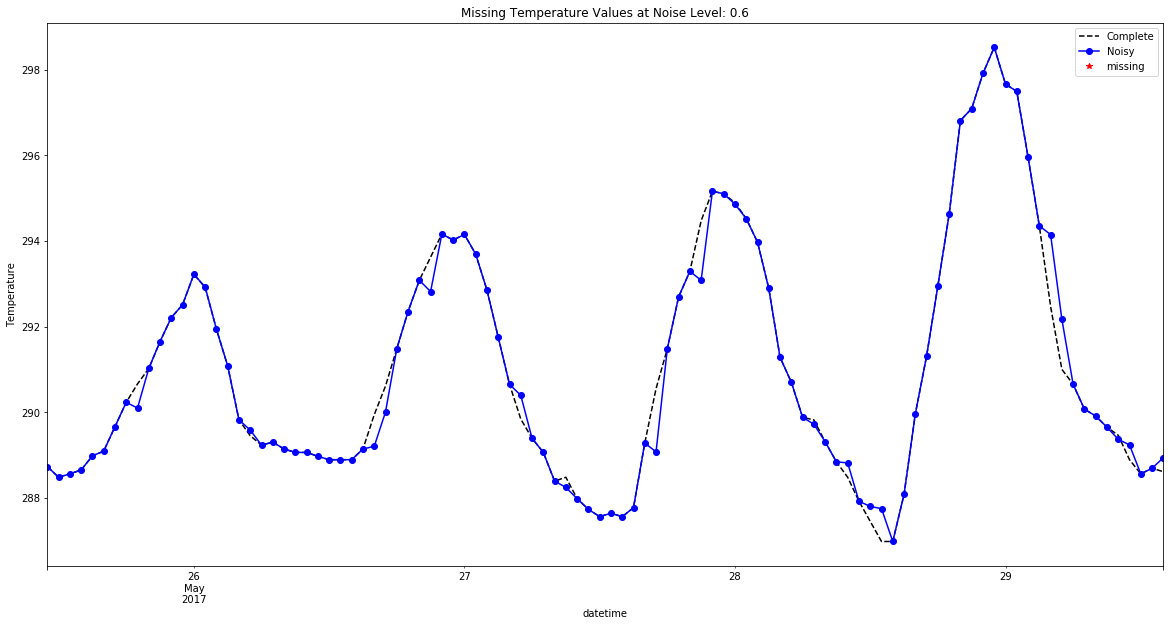

In [181]:
plot_noisy_series(test_df[RESPONSE_VAR], interp_textbook)

In [94]:
interp_linear == interp_textbook

array([ True,  True,  True, ...,  True,  True,  True])

In [89]:
score_interpolation(interp_textbook, test_df['temperature'])

0.2717008129075119